# Irony Detection in English - Task 2

#### The goal of this task is to create a classifier capable of classifing different types of irony

Like the task one that in this [notebook](Irony_Detection_in_English_Tweets.ipynb) we explore with more detail.

### The Dataset

* The dataset used for this task contains the same tweets from the one used in the task 1, but label in a different way

Furthermore we decide to use the data in a different way from the one in the task 1. Instead of using the split in train and test made by the organization we will manipulate the data and try two scenarios in order to use the scikit learn model split function and K-Folds cross validation:

1. Use the train dataset alone
2. Join the train and test datasets making sure they remain balanced

This classification task is not binary as the first one. This task is a multiclass problem. In this task the labels have the following meaning:

0. Non-ironic
1. Ironic by clash
2. Situational irony
3. Other irony
**From this two scenarios, we will choose the one that performs better in a preliminary analyses**

In [1]:
from IPython.display import display, HTML
import pandas
import numpy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_data=pandas.read_csv('data/task2/train.csv',  delimiter = '\t', quoting = 3, encoding="utf-8")
all_data=pandas.read_csv('data/task2/all.csv', delimiter = '\t', quoting = 3, encoding="utf-8")

In [2]:
train_data.head()

,label,tweet
0,1,Sweet United Nations video. Just in time for C...
1,1,@mrdahl87 We are rumored to have talked to Erv...
2,1,Hey there! Nice to see you Minnesota/ND Winter...
3,0,3 episodes left I'm dying over here
4,2,"""I can't breathe!"" was chosen as the most nota..."


In [3]:
all_data.head()

,label,tweet
0,0,@Callisto1947 Can U Help?||More conservatives ...
1,2,"Just walked in to #Starbucks and asked for a ""..."
2,0,#NOT GONNA WIN http://t.co/Mc9ebqjAqj
3,0,@mickymantell He is exactly that sort of perso...
4,1,So much #sarcasm at work mate 10/10 #boring 10...


<AxesSubplot:xlabel='label'>

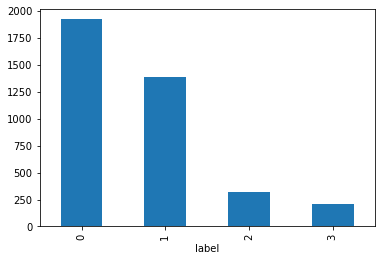

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

train_data.groupby('label').size().plot.bar()

<AxesSubplot:xlabel='label'>

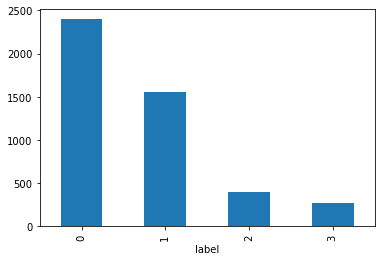

In [5]:
all_data.groupby('label').size().plot.bar()

#### Different from the task 1 the dataset is pretty much unbalanced towards the inexistance of irony in the tweets

This fact could introduced bias in the classficator. This way special attention to the fenomena of overfitting must be taken into account

##### Helper Functions

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji
import re
import contractions
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


def pre_processing_pipeline(dataframe):
    dataframe['tweet'].str.replace('http\S+|www.\S+', '', case=False)
    dataframe['tweet'].str.replace('@\S+', '', case=False)
    dataframe['tweet'].str.replace('\d+', '', case=False)
    dataframe['tweet'].str.replace('#', '', case=False)
    
    emoji_result=[]

    for i in range(len(dataframe)):    
        demojize_result=emoji.demojize(dataframe.loc[i,'tweet'])
        #Remove the ":" from the convertion made by emoji
        demojize_result=re.sub(":", " ", demojize_result)
        demojize_result=re.sub("_", " ", demojize_result)
        demojize_result=re.sub("-", " ", demojize_result)
        emoji_result.append(demojize_result)


    dummy=[]
    for i in range(len(emoji_result)):
        dummy.append(contractions.fix(emoji_result[i]))

    from nltk.stem import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()

    lemmatization_result = []

    for i in range(len(dummy)):
        tweet = lemmatizer.lemmatize(dummy[i])
        lemmatization_result.append(tweet)

    ps = PorterStemmer()
    corpus = []

    for i in range(len(lemmatization_result)):
        # get review and remove non alpha chars
        tweet = re.sub('[^\w_\w]', ' ', lemmatization_result[i])
        # to lower-case and tokenize
        tweet = tweet.lower().split()
        # stemming and stop word removal
        tweet = ' '.join([ps.stem(w) for w in tweet if not w in set(stopwords.words('english'))])
        corpus.append(tweet)

    return corpus

In [7]:
from sklearn.model_selection import train_test_split

def refresh_data(X,y):
    vectorizer = TfidfVectorizer(max_features = 800)

    X=vectorizer.fit_transform(X).toarray()
    y=y.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 29)
    
    
    return (X , y, X_train,y_train,X_test,y_test)

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


def print_stats():
    
    print(classification_report(y_test,y_predicted))
    print(confusion_matrix(y_test, y_predicted))
    accuracy_value=accuracy_score(y_test,y_predicted)
    precision_value=precision_score(y_test,y_predicted,average='weighted')
    f1_value=f1_score(y_test,y_predicted,average='weighted')

    actual_conclusion=pandas.DataFrame(
        {
        'Results':[accuracy_value,precision_value,f1_value],
        } , index=['Accuracy','Precision','F1-Value'])

    print(actual_conclusion.head())
    
    # Confusion Matrix Plot
    cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predicted), display_labels=['0. Non-ironic', 'Ironic by clash', 'Situational irony', 'Other irony'])
    fig, ax = plt.subplots(figsize=(10,10))
    cm.plot(ax=ax,cmap=plt.cm.Blues)
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Cross Validation to Check which solution is the best

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

corpus_test=pre_processing_pipeline(train_data)

X , y, X_train,y_train,X_test,y_test=refresh_data(corpus_test,train_data['label'])

classifier=GaussianNB()

scores=cross_val_score(classifier,X,y,cv=10,scoring='accuracy')

print(scores.mean())

0.32184508268059175


In [10]:
corpus_all=pre_processing_pipeline(all_data)

X , y, X_train,y_train,X_test,y_test=refresh_data(corpus_all,all_data['label'])

classifier=GaussianNB()

scores=cross_val_score(classifier,X,y,cv=10,scoring='accuracy')

print(scores.mean())

0.2886398850607093


#### From this results we can infere that use only the training set will produce better results.

### Handle the Unbalanced Dataset

We will try how the same Naive Bayes model would perform with after applying sampling techniques in order to balance the dataset

In [11]:
from sklearn.utils import resample
from IPython.display import display, HTML
import pandas
import numpy

train_data=pandas.read_csv('data/task2/train.csv',  delimiter = '\t', quoting = 3, encoding="utf-8")

df_majority=train_data[train_data.label==0]
df_minority_1=train_data[train_data.label==1]
df_minority_2=train_data[train_data.label==2]
df_minority_3=train_data[train_data.label==3]

df_minority_1_upsampled = resample(df_minority_1,replace=True,n_samples=1900,random_state=123)
df_minority_2_upsampled = resample(df_minority_2,replace=True,n_samples=1900,random_state=123)
df_minority_3_upsampled = resample(df_minority_3,replace=True,n_samples=1900,random_state=123)

train_data=pandas.concat([df_majority,df_minority_1_upsampled,df_minority_2_upsampled,df_minority_3_upsampled],ignore_index=True)

<AxesSubplot:xlabel='label'>

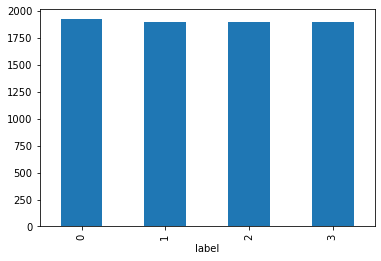

In [12]:
train_data.groupby('label').size().plot.bar()

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

corpus=pre_processing_pipeline(train_data)

X , y, X_train,y_train,X_test,y_test=refresh_data(corpus,train_data['label'])

classifier=GaussianNB()

scores=cross_val_score(classifier,X,y,cv=10,scoring='accuracy')

print(scores.mean())

0.5960856957100547


### Over Sampling Strategy was a success. The oversampled dataset will hold

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.69      0.12      0.20       388
           1       0.67      0.46      0.54       401
           2       0.63      0.85      0.72       357
           3       0.54      1.00      0.70       379

    accuracy                           0.60      1525
   macro avg       0.63      0.61      0.54      1525
weighted avg       0.63      0.60      0.54      1525

[[ 45  92 111 140]
 [ 20 185  64 132]
 [  0   1 302  54]
 [  0   0   0 379]]
            Results
Accuracy   0.597377
Precision  0.632944
F1-Value   0.537158


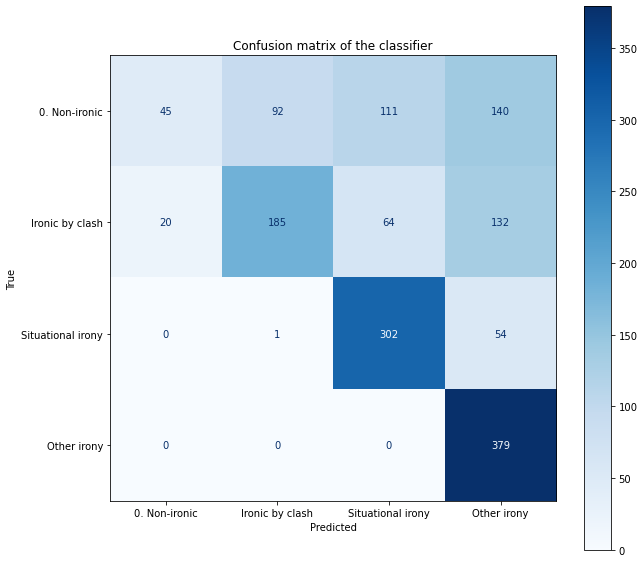

In [14]:
corpus=pre_processing_pipeline(train_data)

X, y, X_train,y_train,X_test,y_test=refresh_data(corpus,train_data['label'])

classifier=GaussianNB()

classifier.fit(X_train,y_train)

y_predicted=classifier.predict(X_test)

print_stats()

In [15]:
corpus=pre_processing_pipeline(train_data)

X, y, X_train,y_train,X_test,y_test=refresh_data(corpus,train_data['label'])

classifier=GaussianNB()

classifier.fit(X_train,y_train)

GaussianNB()

#### Neural Network

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       388
           1       0.80      0.82      0.81       401
           2       0.92      1.00      0.96       357
           3       0.95      1.00      0.97       379

    accuracy                           0.87      1525
   macro avg       0.87      0.87      0.87      1525
weighted avg       0.87      0.87      0.87      1525

[[265  84  25  14]
 [ 63 327   4   7]
 [  0   0 357   0]
 [  0   0   0 379]]
            Results
Accuracy   0.870820
Precision  0.866755
F1-Value   0.866904


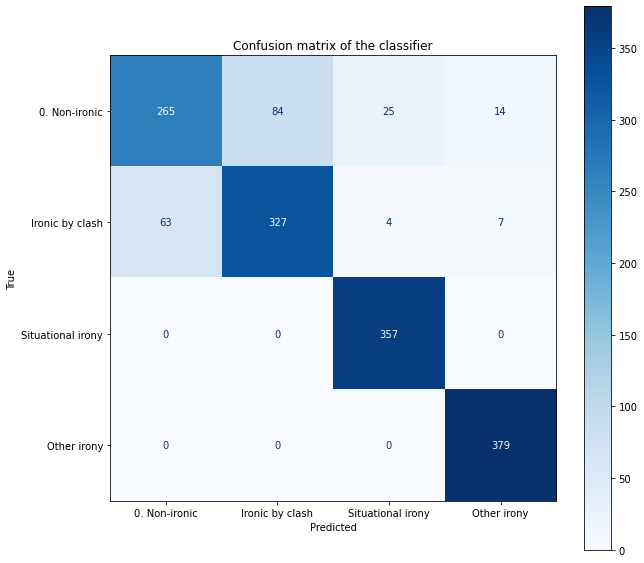

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

corpus=pre_processing_pipeline(train_data)
X, y, X_train,y_train,X_test,y_test=refresh_data(corpus,train_data['label'])

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = MLPClassifier(max_iter=1500,activation='relu',solver='adam')

classifier.fit(X_train,y_train)

y_predicted=classifier.predict(X_test)

print_stats()

#### Decision Tree

##### Grid Search

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

corpus=pre_processing_pipeline(train_data)
X, y, X_train,y_train,X_test,y_test=refresh_data(corpus,train_data['label'])

param_grid = { 'criterion':['gini','entropy'],'max_depth': numpy.arange(2, 15)}
# decision tree model
classifier=DecisionTreeClassifier()

#use gridsearch to test all values
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)

print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 14}


              precision    recall  f1-score   support

           0       0.61      0.91      0.73       388
           1       0.53      0.49      0.51       401
           2       0.80      0.91      0.85       357
           3       0.87      0.40      0.55       379

    accuracy                           0.67      1525
   macro avg       0.70      0.68      0.66      1525
weighted avg       0.70      0.67      0.66      1525

[[353  21   9   5]
 [177 197  14  13]
 [  7  21 324   5]
 [ 39 131  58 151]]
            Results
Accuracy   0.672131
Precision  0.698880
F1-Value   0.655505


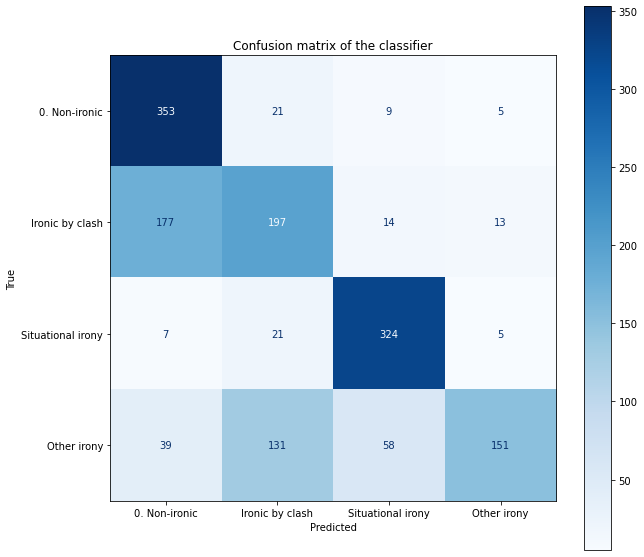

In [18]:
corpus=pre_processing_pipeline(train_data)
X, y, X_train,y_train,X_test,y_test=refresh_data(corpus,train_data['label'])

# decision tree model
classifier=DecisionTreeClassifier(criterion='gini',max_depth=14)

classifier.fit(X_train,y_train)

y_predicted=classifier.predict(X_test)

print_stats()

### Classificators compare

## Appendix:

#### Oversampling in Task 1

Since the oversampling worked great for the Task 2 with a neural network. It is usefull to test if the same strategy can be applied to the dataset used in the task 1.


In [19]:
train_data=pandas.read_csv('data/task1/train.csv',  delimiter = '\t', quoting = 3, encoding="utf-8")
test_data=pandas.read_csv('data/task1/test-labeled.csv', delimiter = '\t', quoting = 3, encoding="utf-8")

In [20]:
from sklearn.utils import resample
df_non_ironic=train_data[train_data.label==0]
df_ironic=train_data[train_data.label==1]

df_non_ironic_upsampled = resample(df_non_ironic,replace=True,n_samples=8000,random_state=123)
df_ironic_upsampled = resample(df_ironic,replace=True,n_samples=8000,random_state=123)

train_data=pandas.concat([df_non_ironic_upsampled,df_ironic_upsampled],ignore_index=True)

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       473
           1       0.49      0.56      0.52       311

    accuracy                           0.59       784
   macro avg       0.58      0.59      0.58       784
weighted avg       0.60      0.59      0.60       784

[[290 183]
 [137 174]]
            Results
Accuracy   0.591837
Precision  0.603088
F1-Value   0.595459


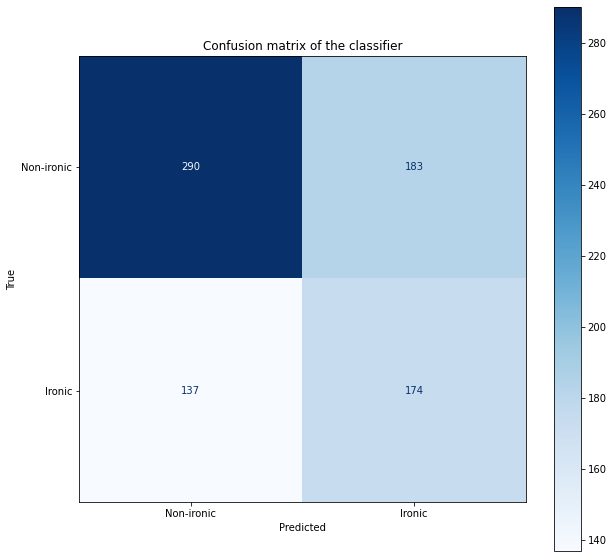

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

corpus=pre_processing_pipeline(train_data)

vectorizer = TfidfVectorizer(max_features = 800)

X_train=vectorizer.fit_transform(corpus).toarray()
y_train=train_data['label'].copy()
    
X_test=vectorizer.transform(test_data['tweet']).toarray()
y_test=test_data['label']


scaler = StandardScaler()
classificator = MLPClassifier(max_iter=1500,activation='relu',solver='adam')

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_test=test_data['label']


classificator.fit(X_train, y_train)
y_predicted = classificator.predict(X_test)



print(classification_report(y_test,y_predicted))
print(confusion_matrix(y_test, y_predicted))

accuracy_value=accuracy_score(y_test,y_predicted)
precision_value=precision_score(y_test,y_predicted,average='weighted')
f1_value=f1_score(y_test,y_predicted,average='weighted')
actual_conclusion=pandas.DataFrame(
{
'Results':[accuracy_value,precision_value,f1_value],
} , index=['Accuracy','Precision','F1-Value'])

print(actual_conclusion.head())
    
# Confusion Matrix Plot
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predicted), display_labels=['Non-ironic', 'Ironic'])
fig, ax = plt.subplots(figsize=(10,10))
cm.plot(ax=ax,cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### It didn't improved the result obtain in the first task

If we make a clear separation of the train and test dataset, we avoid overfitting, but in the other hand our result get more realistic and get worse.

**The oversampling have decrease the quality of our solution** For the first task scenario

## Conclusions of the Task 2